In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use('fivethirtyeight')

## Principal Component Analysis

This [tutorial](https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/chapters/Week7/Intro_to_PCA.html) inspired the code below

In [2]:
iri_url = "http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/"
T_convert = "T/[(days)(since)(1960-01-01)]sconcat/streamgridunitconvert/"

# complete url
url = iri_url + T_convert + "dods"

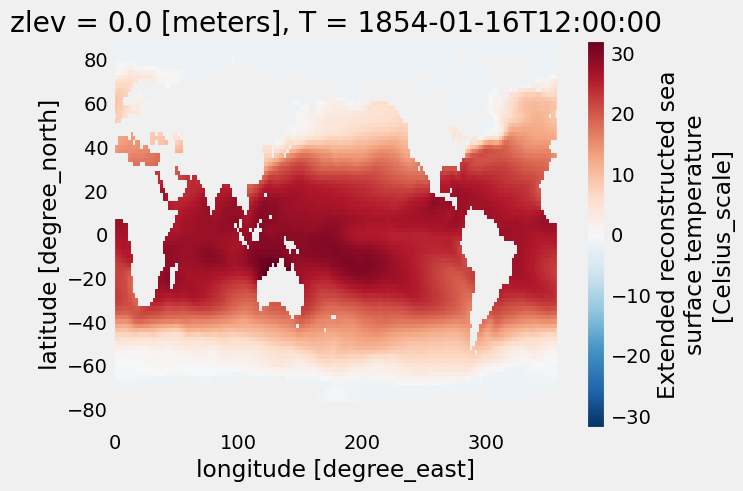

In [3]:
# open the dataset
ds = xr.open_dataset(url)

# plot the data
ds.sst[0].plot()

## Compute ENSO3.4 Mean

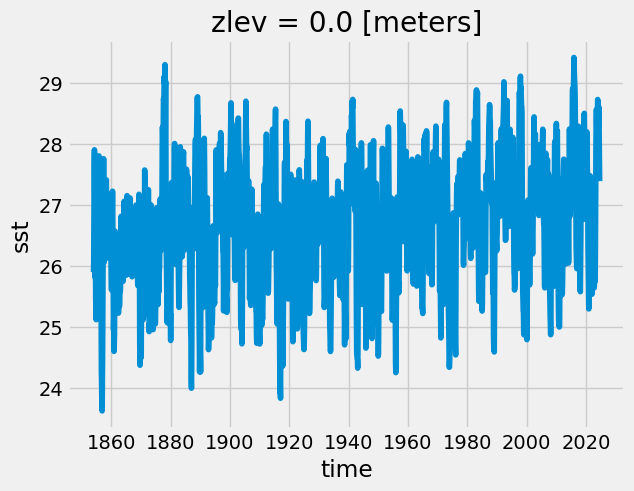

In [4]:
# Compute average SST in a box from 5N to 5S and 170W to 120W
nino34_mean = ds.sst.sel(Y=slice(-5, 5), X=slice(360-170, 360-120)).mean(dim=['Y','X'])

# plot the data
nino34_mean.plot();

## Compute the SST Anomaly

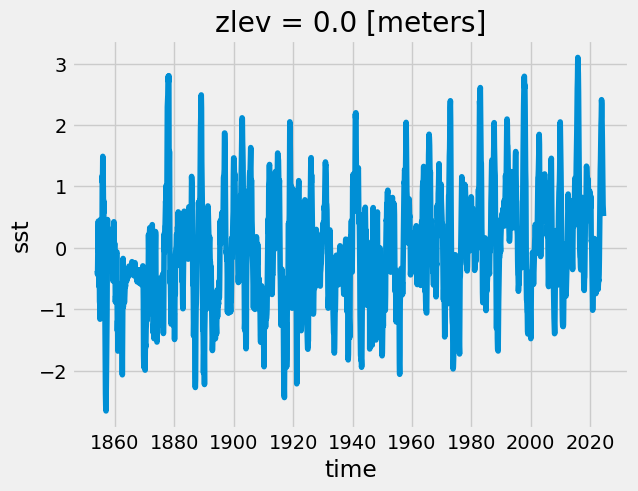

In [5]:
# compute 1950-1979 monthly climatology
climatology = nino34_mean.sel(T=slice('1950-01-01', '1979-12-31')).groupby('T.month').mean(dim='T')

# compute anomalies
anomalies = nino34_mean.groupby('T.month') - climatology

# plot the data
anomalies.plot();

## Calculate 5-month running mean

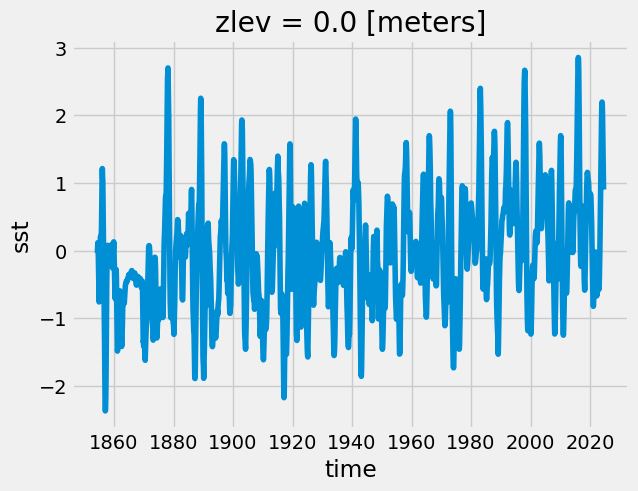

In [6]:
# calculate 5-month running mean
running_mean = anomalies.rolling(T=5).mean()

# plot the data
running_mean.plot();

# Standardize using standard deviation

In [7]:
# standardize the running mean by the standard deviation of the climatology
nino34_index = running_mean / climatology.std()

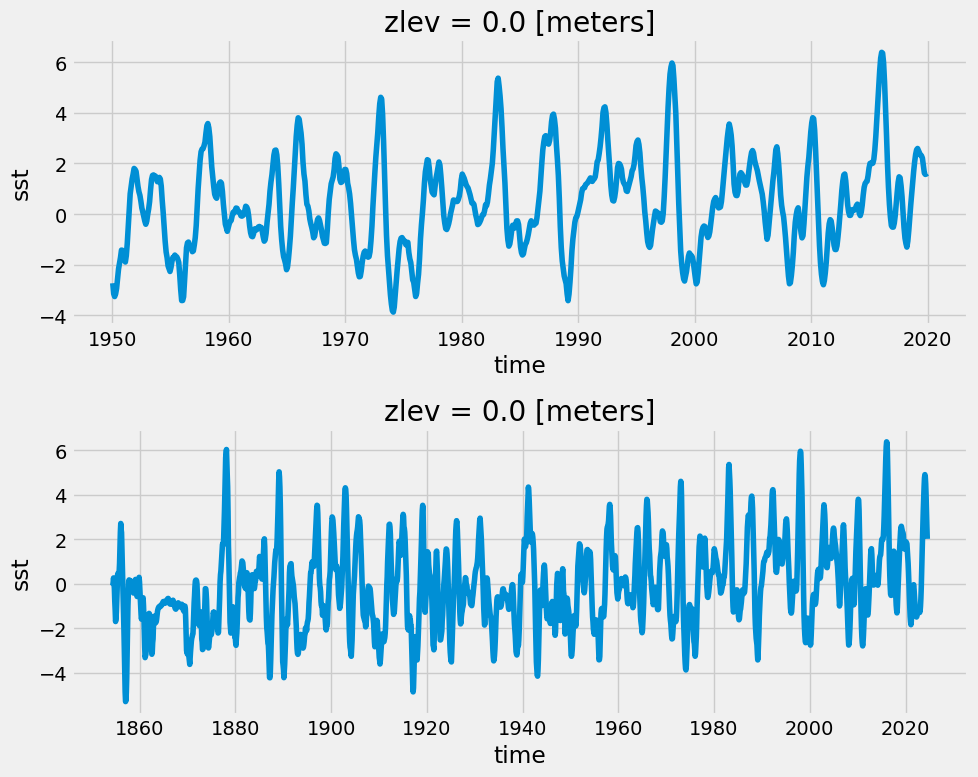

In [8]:
# plot last 70 years of data then the entire time series, using two rows of plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
nino34_index.sel(T=slice('1950-01-01', '2019-12-31')).plot(ax=ax[0])
nino34_index.plot(ax=ax[1])
plt.tight_layout()

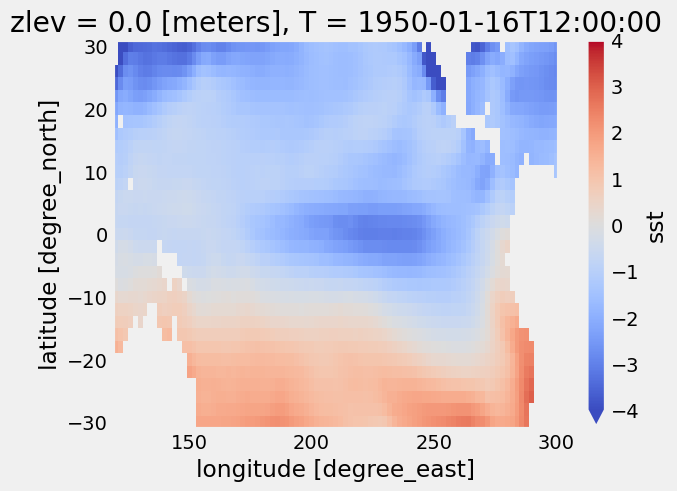

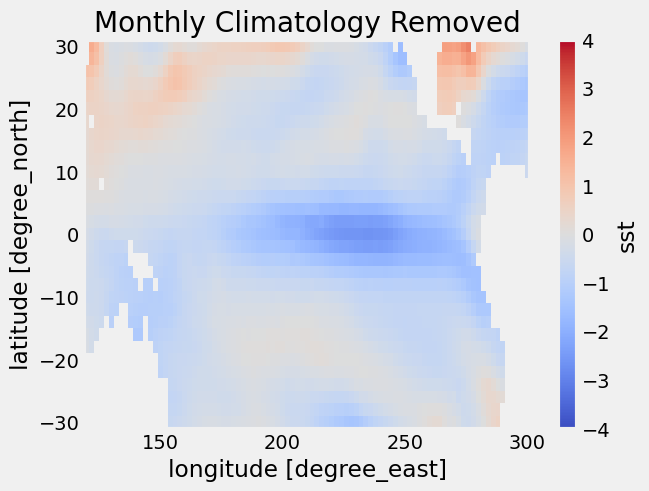

In [9]:
# extract larger spatial domain... 30S to 30N and 120E to 300E
nino34_large = ds.sst.sel(Y=slice(-30, 30), X=slice(120, 300))

# select 1950-2019  
nino34_large = nino34_large.sel(T=slice('1950-01-01', '2019-12-31'))

# remove time mean to get anomalies
time_mean = nino34_large.mean(dim='T')
ssta_pac = nino34_large - time_mean

# set the range of anomalies to plot
ssta_pac[0].plot(vmin=-4, vmax=4, cmap='coolwarm')

# remove the monthly climatology
monthly_climo = nino34_large.groupby('T.month').mean(dim='T')
monthly_climate_removed = nino34_large.groupby('T.month') - monthly_climo

# plot anomalies_large on a new figure
plt.figure()
monthly_climate_removed[0].plot(vmin=-4, vmax=4, cmap='coolwarm')
plt.title('Monthly Climatology Removed')

plt.show()

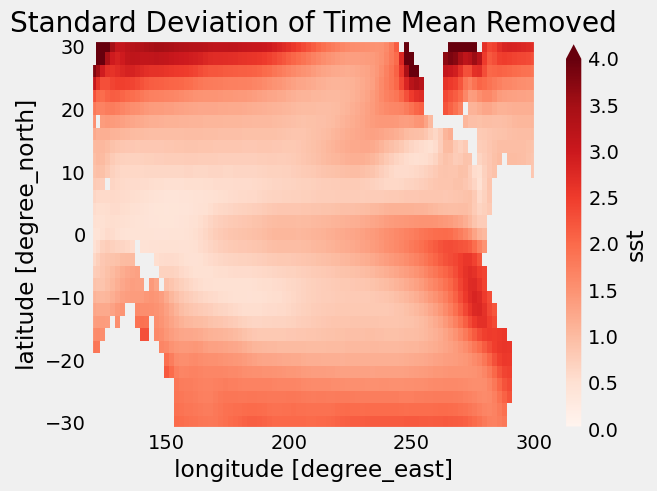

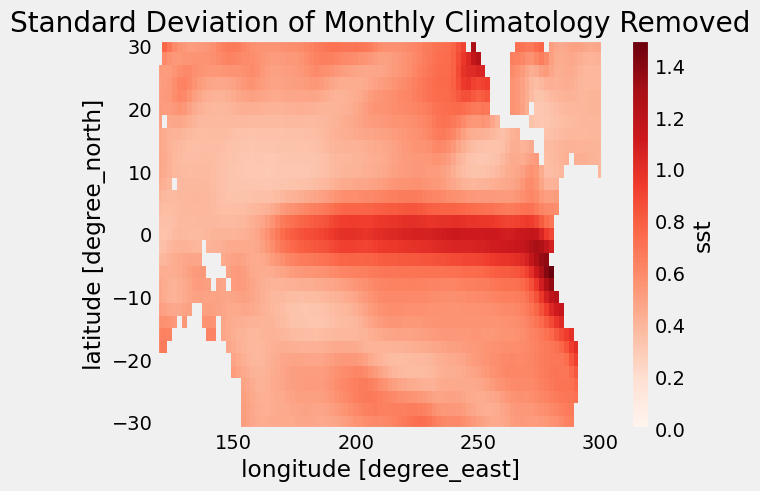

In [10]:
# standard deviation of time mean removed
std_ssta_pac = ssta_pac.std(dim='T')
std_ssta_pac.plot(cmap='Reds', vmin=0, vmax=4)
plt.title('Standard Deviation of Time Mean Removed')
plt.show()

# standard deviation of monthly climatology removed
std_monthly_climate_removed = monthly_climate_removed.std(dim='T')
std_monthly_climate_removed.plot(cmap='Reds', vmin=0, vmax=1.5)
plt.title('Standard Deviation of Monthly Climatology Removed')
plt.show()

Percentage of variance explained by the first two PCs: [0.60821027 0.16482107]


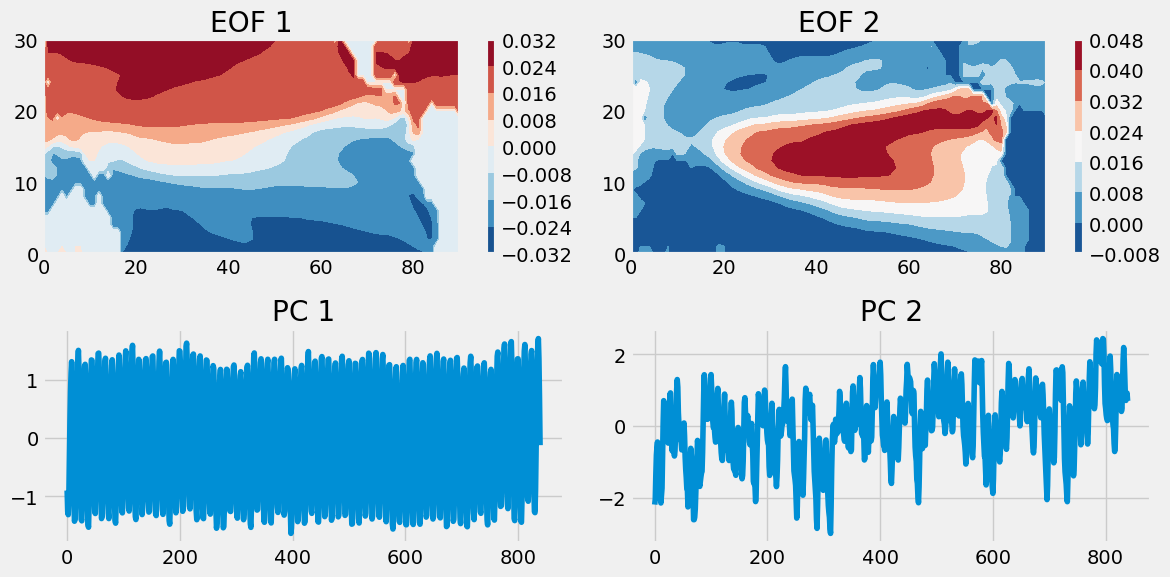

In [11]:
# Fill NaN values with 0
ssta_pac_filled = ssta_pac.fillna(0)

# select zlev=1
ssta_pac_filled = ssta_pac_filled.isel(zlev=0)

# Assuming the dimensions are ['T', 'Y', 'X']
time_dim, lat_dim, lon_dim = ssta_pac_filled.shape

# Reshape the data to 2D (combine spatial dimensions)
ssta_pac_reshaped = ssta_pac_filled.values.reshape(time_dim, lat_dim * lon_dim)

# Standardize the data between -1 and 1
scaler = StandardScaler()
ssta_pac_standardized = scaler.fit_transform(ssta_pac_reshaped)

# Perform PCA
pca = PCA(n_components=2)
pca.fit(ssta_pac_standardized)

# Extract the first two EOFs
eof1 = pca.components_[0].reshape(lat_dim, lon_dim)
eof2 = pca.components_[1].reshape(lat_dim, lon_dim)

# Calculate percentage of variance explained
explained_variance = pca.explained_variance_ratio_

print('Percentage of variance explained by the first two PCs:', explained_variance)

# Calculate the PCs
pc1 = pca.transform(ssta_pac_standardized)[:, 0]
pc2 = pca.transform(ssta_pac_standardized)[:, 1]

# Standardize the PCs
scaler_pc = StandardScaler()
pc1 = scaler_pc.fit_transform(pc1.reshape(-1, 1)).flatten()
pc2 = scaler_pc.fit_transform(pc2.reshape(-1, 1)).flatten()

# Plot the first two EOFs
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.contourf(eof1, cmap='RdBu_r',)
plt.colorbar()
plt.title('EOF 1')

plt.subplot(2, 2, 2)
plt.contourf(eof2, cmap='RdBu_r',)
plt.colorbar()
plt.title('EOF 2')

# Plot the first two PCs
plt.subplot(2, 2, 3)
plt.plot(pc1)
plt.title('PC 1')

plt.subplot(2, 2, 4)
plt.plot(pc2)
plt.title('PC 2')

plt.tight_layout()
plt.show()


## Plot PC2 vs Nino3.4 Index

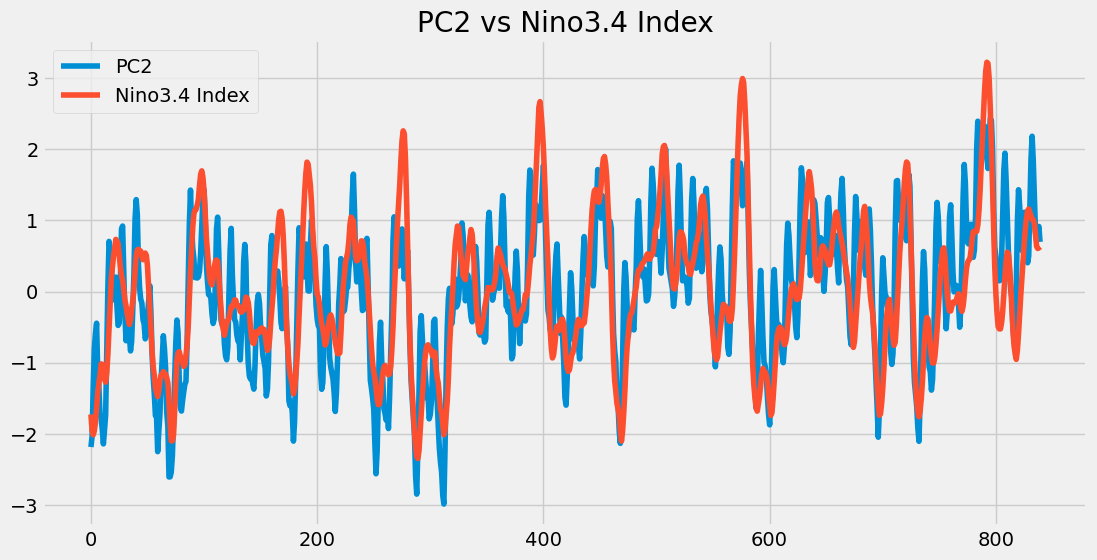

In [12]:
recent_enso34 = nino34_index.sel(T=slice('1950-01-01', '2019-12-31'))
scaler_nino = StandardScaler()
recent_enso34 = scaler_nino.fit_transform(recent_enso34.values.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))
plt.plot(pc2, label='PC2')
plt.plot(recent_enso34, label='Nino3.4 Index')
plt.title('PC2 vs Nino3.4 Index')
plt.legend()
plt.show()